In [3]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np
from scipy.special import erfcinv
from scipy.stats import chi2, multivariate_normal, gamma
from scipy.special import erfinv, erf, erfc
from scipy.linalg import sqrtm, inv

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path to git repo: /home/matias/Documents/PhD/code


# Three moltivariate distributions

In [4]:
#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[1, 0.], [0., 1]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

In [5]:
#Define some functions:

def calculate_quadratic_form_sum(vectors):
    return sum(np.dot(v, v) for v in vectors)

def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM

def construct_K(vectors):
    num_vectors = len(vectors)

    R_CM = calculate_R_CM(vectors)

    K_xx = np.sum((vectors[:, 0] - R_CM[0]) ** 2)
    K_yy = np.sum((vectors[:, 1] - R_CM[1]) ** 2)
    K_xy = np.sum((vectors[:, 0] - R_CM[0]) * (vectors[:, 1] - R_CM[1]))
    K_yx = K_xy
    K = np.array([[K_xx, K_xy], [K_yx, K_yy]])
    return K

In [6]:
r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))

# Example usage:
vectors = np.array([r_1, r_2, r_3])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

Q_2 = calculate_quadratic_form_sum(vectors)
print('Quadratic form sum: {}'.format(Q_2))

# Example usage:
K = construct_K(vectors)
print('Tensor of Inertia: {}'.format(K))

Center of mass: [-0.23570226 -0.40824829]
Quadratic form sum: 1.5000000000000004
Tensor of Inertia: [[ 0.58333333 -0.28867513]
 [-0.28867513  0.25      ]]


# Distribution of $|R_{CM}|^2=\left(\frac{\sum_i |r_i|}{L}\right)^2$

In [7]:
def Q_tot(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, L, H0=False):
    cov_1 = cov_A + cov_B
    cov_2 = cov_A + cov_C
    cov_3 = cov_B + cov_C
    #cov_4 = cov_A + cov_D
    #cov_5 = cov_B + cov_D
    #cov_6 = cov_C + cov_D


    DA = np.random.multivariate_normal(mean_A, cov_A, size=n_samples)
    DB = np.random.multivariate_normal(mean_B, cov_B, size=n_samples)
    DC = np.random.multivariate_normal(mean_C, cov_C, size=n_samples)
    #DD = np.random.multivariate_normal(mean_D, cov_D, size=n_samples)
    

    # Sampling
    sample_1 = np.dot(sqrtm(np.linalg.inv(cov_1)), np.array(DA-DB).T)  # Shape: (d, n_samples)
    sample_2 = np.dot(sqrtm(np.linalg.inv(cov_2)), np.array(DA-DC).T)  # Shape: (d, n_samples)
    sample_3 = np.dot(sqrtm(np.linalg.inv(cov_3)), np.array(DB-DC).T)  # Shape: (d, n_samples)
    #sample_4 = np.dot(sqrtm(np.linalg.inv(cov_4)), np.array(DA-DD).T)  # Shape: (d, n_samples)
    #sample_5 = np.dot(sqrtm(np.linalg.inv(cov_5)), np.array(DB-DD).T)  # Shape: (d, n_samples)
    #sample_6 = np.dot(sqrtm(np.linalg.inv(cov_6)), np.array(DC-DD).T)  # Shape: (d, n_samples)

    if H0==True:
        sample_1_H0 = sample_1 - np.mean(sample_1, axis=1, keepdims=True)
        sample_2_H0 = sample_2 - np.mean(sample_2, axis=1, keepdims=True)
        sample_3_H0 = sample_3 - np.mean(sample_3, axis=1, keepdims=True)
        #sample_4_H0 = sample_4 - np.mean(sample_4, axis=1, keepdims=True)
        #sample_5_H0 = sample_5 - np.mean(sample_5, axis=1, keepdims=True)
        #sample_6_H0 = sample_6 - np.mean(sample_6, axis=1, keepdims=True)
        
        r_tot = sample_1_H0 + sample_2_H0 + sample_3_H0 
               #+ sample_4_H0 + sample_5_H0 +  sample_6_H0
                
    else:
        r_tot = sample_1 + sample_2 + sample_3 #+ sample_4 + sample_5 + sample_6

    Q = np.zeros(n_samples)  # Initialize W
    for i in range(n_samples):
        Q[i] = np.dot(r_tot[:, i], r_tot[:, i])  # Shape: (n_samples,)

    return Q / L**2

def Q_tot_alt(n_samples, D, L, H0=False):
    
    #C = 0.5*np.eye(L*D) + 0.5*np.ones((L*D,L*D))

    C = np.array([[1,  0,  1/2,  0,  -1/2,  0],
                  [0,  1,  0,  1/2,  0,  -1/2],
                  [1/2,  0,  1,  0  ,1/2  ,0],
                  [0,  1/2,  0,  1,  0,  1/2],
                  [-1/2,  0,  1/2,  0,  1,  0],
                  [0,  -1/2,  0,  1/2,  0,  1]])
    
    W = np.random.multivariate_normal(np.zeros(L*D), C, size=n_samples)

    N = np.array([[1,0,1,0,1,0],
                  [0,1,0,1,0,1],
                  [1,0,1,0,1,0],
                  [0,1,0,1,0,1],
                  [1,0,1,0,1,0],
                  [0,1,0,1,0,1]])
    print(W.shape)
    Q = np.zeros(n_samples)  # Initialize W
    for i in range(n_samples):
        Q[i] = np.dot(W[i, :], np.dot(N,W[i, :]))  # Shape: (n_samples,)
        #print(Q[i])

    return Q / L**2

Plot this information:

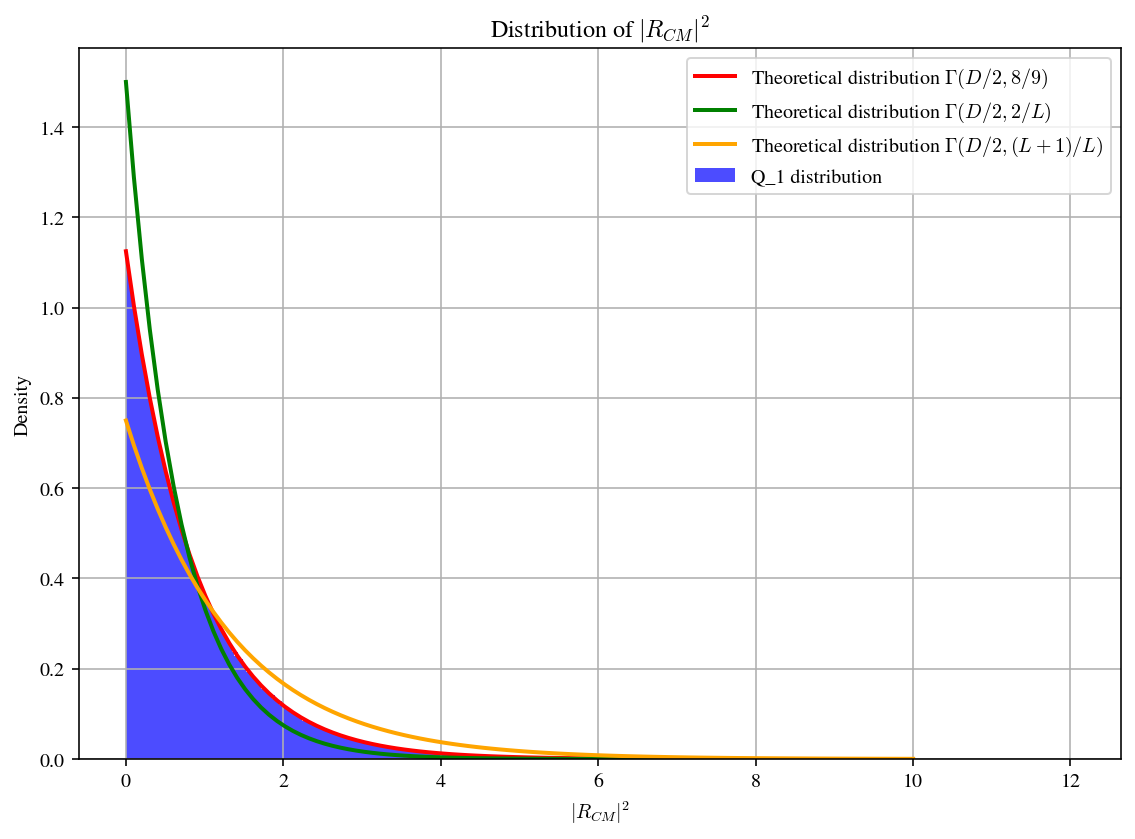

In [8]:
#Sharp triangle
D = 2
L = 3  # Number of vector
N_samples = int(1e6)  # Number of samples 

Q_1s = Q_tot(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, N_samples, L, H0=True)

dist_th_1 = gamma(a=D/2, scale=2*4/L**2)
dist_th_2 = gamma(a=D/2, scale=2/L)
dist_th_3 = gamma(a=D/2, scale=(L+1)/L)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(Q_1s, bins=int(np.sqrt(len(Q_1s))), density=True, alpha=0.7, color='blue', label='Q_1 distribution')
ax.plot(np.linspace(0, 10, 100), dist_th_1.pdf(np.linspace(0, 10, 100)), color='red', label='Theoretical distribution $\Gamma(D/2, 8/9)$', linewidth=2)
ax.plot(np.linspace(0, 10, 100), dist_th_2.pdf(np.linspace(0, 10, 100)), color='green', label='Theoretical distribution $\Gamma(D/2, 2/L)$', linewidth=2)
ax.plot(np.linspace(0, 10, 100), dist_th_3.pdf(np.linspace(0, 10, 100)), color='orange', label='Theoretical distribution $\Gamma(D/2, (L+1)/L)$', linewidth=2)
ax.set_xlabel(r'$|R_{CM}|^2$')
ax.set_ylabel('Density')
ax.set_title(r'Distribution of $|R_{CM}|^2$')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()


(1000000, 6)


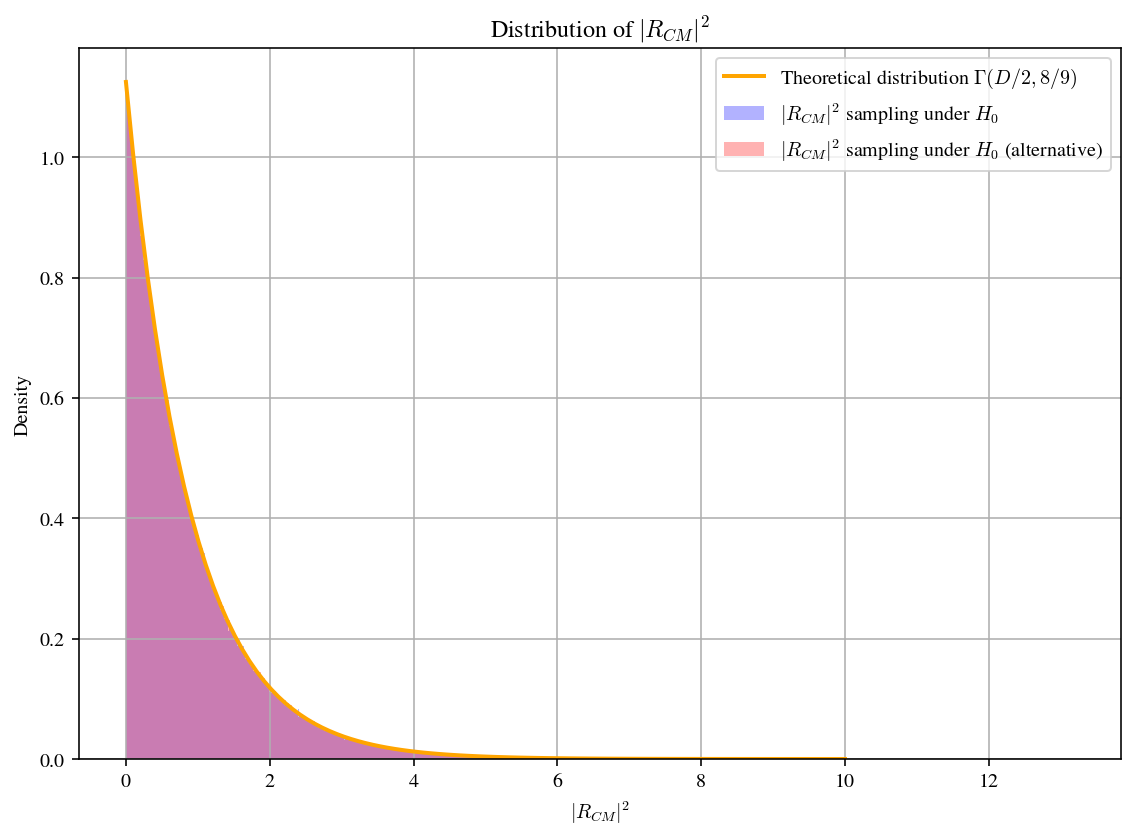

In [9]:
#Sharp triangle
D = 2
L = 3  # Number of vector
N_samples = int(1e6)  # Number of samples

Q_1s = Q_tot(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, N_samples, L, H0=True)
Q_2s = Q_tot_alt(N_samples, D, L, H0=True)
dist_th_1 = gamma(a=D/2, scale=2*4/L**2)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(Q_1s, bins=int(np.sqrt(len(Q_1s))), density=True, alpha=0.3, color='blue', label=r'$|R_{CM}|^2$ sampling under $H_0$')
ax.hist(Q_2s, bins=int(np.sqrt(len(Q_2s))), density=True, alpha=0.3, color='red', label=r'$|R_{CM}|^2$ sampling under $H_0$ (alternative)')

ax.plot(np.linspace(0, 10, 100), dist_th_1.pdf(np.linspace(0, 10, 100)), color='orange', label='Theoretical distribution $\Gamma(D/2,8/9)$', linewidth=2)

ax.set_xlabel(r'$|R_{CM}|^2$')
ax.set_ylabel('Density')
ax.set_title(r'Distribution of $|R_{CM}|^2$')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()


# Distribution of $\frac{\sum_i^L |r_i|^2}{L}$

In [17]:
def Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, L, H0=False):
    cov_1 = cov_A + cov_B
    cov_2 = cov_A + cov_C
    cov_3 = cov_B + cov_C
    #cov_4 = cov_A + cov_D
    #cov_5 = cov_B + cov_D
    #cov_6 = cov_C + cov_D


    DA = np.random.multivariate_normal(mean_A, cov_A, size=n_samples)
    DB = np.random.multivariate_normal(mean_B, cov_B, size=n_samples)
    DC = np.random.multivariate_normal(mean_C, cov_C, size=n_samples)
    #DD = np.random.multivariate_normal(mean_D, cov_D, size=n_samples)
    

    # Sampling
    sample_1 = np.dot(sqrtm(np.linalg.inv(cov_1)), np.array(DA-DB).T)  # Shape: (d, n_samples)
    sample_2 = np.dot(sqrtm(np.linalg.inv(cov_2)), np.array(DA-DC).T)  # Shape: (d, n_samples)
    sample_3 = np.dot(sqrtm(np.linalg.inv(cov_3)), np.array(DB-DC).T)  # Shape: (d, n_samples)
    #sample_4 = np.dot(sqrtm(np.linalg.inv(cov_4)), np.array(DA-DD).T)  # Shape: (d, n_samples)
    #sample_5 = np.dot(sqrtm(np.linalg.inv(cov_5)), np.array(DB-DD).T)  # Shape: (d, n_samples)
    #sample_6 = np.dot(sqrtm(np.linalg.inv(cov_6)), np.array(DC-DD).T)  # Shape: (d, n_samples)

    if H0==True:
        sample_1_H0 = sample_1 - np.mean(sample_1, axis=1, keepdims=True)
        sample_2_H0 = sample_2 - np.mean(sample_2, axis=1, keepdims=True)
        sample_3_H0 = sample_3 - np.mean(sample_3, axis=1, keepdims=True)
        #sample_4_H0 = sample_4 - np.mean(sample_4, axis=1, keepdims=True)
        #sample_5_H0 = sample_5 - np.mean(sample_5, axis=1, keepdims=True)
        #sample_6_H0 = sample_6 - np.mean(sample_6, axis=1, keepdims=True)
        
        Q = np.zeros(n_samples)
        for i in range(n_samples):
            Q[i] = np.linalg.norm(sample_1_H0[:,i])**2 + np.linalg.norm(sample_2_H0[:,i])**2 + np.linalg.norm(sample_3_H0[:,i])**2       
    else:
        Q = np.zeros(n_samples)
        for i in range(n_samples):
            Q[i] = np.linalg.norm(sample_1[:,i])**2 + np.linalg.norm(sample_2[:,i])**2 + np.linalg.norm(sample_3[:,i])**2

    return Q / L



def Q_tot_alt_quad(n_samples, D, L, H0=False):
    
    #C = 0.5*np.eye(L*D) + 0.5*np.ones((L*D,L*D))

    C = np.array([[1,  0,  1/2,  0,  -1/2,  0],
                  [0,  1,  0,  1/2,  0,  -1/2],
                  [1/2,  0,  1,  0  ,1/2  ,0],
                  [0,  1/2,  0,  1,  0,  1/2],
                  [-1/2,  0,  1/2,  0,  1,  0],
                  [0,  -1/2,  0,  1/2,  0,  1]])
    
    W = np.random.multivariate_normal(np.zeros(L*D), C, size=n_samples)

    N = np.eye(L*D)

    Q = np.zeros(n_samples)  # Initialize W
    for i in range(n_samples):
        Q[i] = np.dot(W[i, :], np.dot(N,W[i, :]))  # Shape: (n_samples,)
        #print(Q[i])

    return Q / L


In [18]:
Q_1s = Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, N_samples, L, H0=True)
print(Q_1s)

[1.22650084 3.8608508  0.91014301 ... 3.60249909 0.86186427 4.54242782]


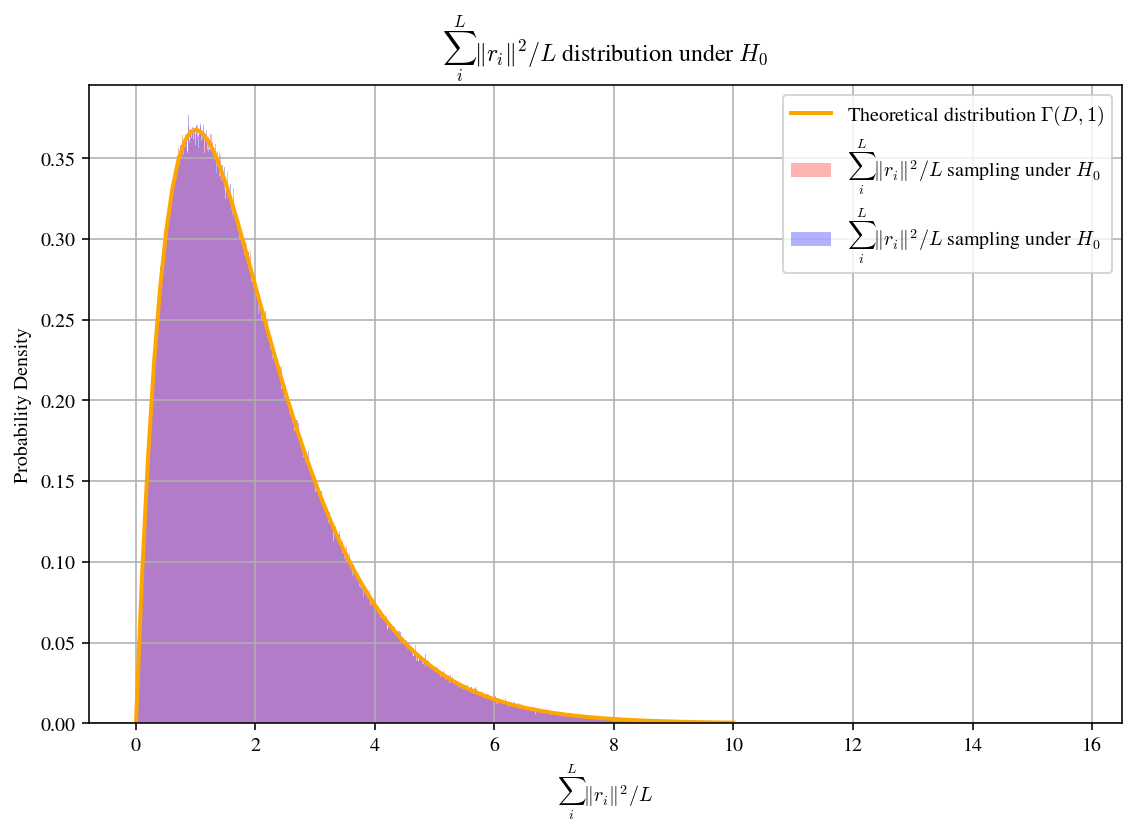

In [19]:
#Sharp triangle
N_samples = int(1e6)  # Number of samples
D = 2
L = 3  # Number of vector

Q_1s = Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, N_samples, L, H0=True)
Q_2s = Q_tot_alt_quad(N_samples, D, L, H0=True)
dist_th_1 = gamma(a=D, scale=1)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(Q_1s, bins=int(np.sqrt(len(Q_1s))), density=True, alpha=0.3, color='red', label=r'$\sum_i^L \|r_i\|^2 / L$ sampling under $H_0$')
ax.hist(Q_2s, bins=int(np.sqrt(len(Q_2s))), density=True, alpha=0.3, color='blue', label=r'$\sum_i^L \|r_i\|^2 / L$ sampling under $H_0$')

ax.plot(np.linspace(0, 10, 100), dist_th_1.pdf(np.linspace(0, 10, 100)), color='orange', label='Theoretical distribution $\Gamma(D,1)$', linewidth=2)
ax.set_xlabel(r'$\sum_i^L \|r_i\|^2 / L$')
ax.set_ylabel('Probability Density')
ax.set_title(r'$\sum_i^L \|r_i\|^2 / L$ distribution under $H_0$')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()